In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 15
# plt.rcParams['figure.figsize'] = (10,7)
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

### Plotting scripts

In [73]:
def plot_learning_curve(files, item='reward', window=1000, sample=1, firstn=-1,
                        title=None, h_line=None, out_location=None, final=False, y_lims=None, plot_all_runs=False,
                        print_final_reward_rate=False, print_max_value_over_last_tenth=False):

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    which_step_size = 'alpha_w'
    for i, (location, filename) in enumerate(files):
        data = np.load(location + filename, allow_pickle=True).item()
        rewards_train = data[item][:,:firstn]
        if data['params']['robust_to_initialization']:
            rewards_train -= data['params']['reward_offset']
        max_run_length = rewards_train.shape[1]
        if print_final_reward_rate:
#             print(f'Learned reward rate: {np.mean(data["avgrew"][:,-10:], axis=1)}')
#             print(f'Over {data["params"]["num_runs"]} runs: {np.mean(data["avgrew"][:,-10:])} +- {np.std(data["avgrew"][:,-10:])}')
            print(f'Learned reward rate: {np.mean(data["avgrew_final"])}')
        if print_max_value_over_last_tenth:
            print(f'Max value over the last 10% steps: {np.nanmean(data["max_value_per_step"])}\n')
        conv_arr = np.ones(window)
        reward_rate_all = []
        x_s = np.arange(window, max_run_length+1)[::sample] #* data['params']['eval_every_n_steps']
        # ToDo: vectorize this
        for run in range(rewards_train.shape[0]):
            reward_rate = np.convolve(rewards_train[run,:], conv_arr, mode='valid') / window
            reward_rate_all.append(reward_rate)
            if plot_all_runs:
                plt.plot(x_s, reward_rate, alpha=0.1, color=colors[i % len(colors)])
        reward_rate_all = np.array(reward_rate_all)
        mean = np.mean(reward_rate_all, axis=0)
        stderr = np.std(reward_rate_all, axis=0) / np.sqrt(reward_rate_all.shape[0])
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        agent_name = data['params']['agent_name']
        plt.plot(x_s, y_s, label=agent_name, color=colors[i % len(colors)])
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3)

    if h_line!= None:
        plt.axhline(y=h_line, color='black', alpha=0.3, linestyle='--')
    plt.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    if y_lims != None:
        plt.ylim(y_lims[0], y_lims[1])
    if not final:
        plt.legend()
        plt.title(title)
    plt.tight_layout()
#     if final:
#         assert os.path.isfile(out_location + title + '.png') == False, "File already exists. Don't overwrite!"
#         plt.savefig(out_location + title + '.png', dpi=1200, transparent=True)
    plt.show()

from utils.tilecoder import TileCoder
    
def plot_values(filename, run_idx=None):
    data = np.load(filename, allow_pickle=True).item()
    weights = data['weights_final']
    num_runs = weights.shape[0]
    tilecoder = TileCoder(tiling_dims=data['params']['tiling_dims'], 
                          limits_per_dim=data['params']['limits_per_dim'], 
                          num_tilings=data['params']['num_tilings'], style='indices')
    num_features = tilecoder.n_tiles
#     print(num_features)
    num_test_points = 200
    angles = np.linspace(0, 2*np.pi, num_test_points)
    values = np.zeros((num_test_points, 3))
    X = np.array([np.sin(angles), np.cos(angles)]).T
#     print(weights[run_idx][:129])
    
    for i, x in enumerate(X):
        for action in range(3):
            obs = tilecoder.getitem(x)
            obs = np.concatenate((obs, [num_features]))  # bias feature
            offset = (num_features+1) * action
            state = np.array(obs + offset, dtype=int)
#             print(state)
            if run_idx is not None:
                values[i,action] = np.sum(weights[run_idx,state])
            else:
                values[i,action] = np.sum(weights[:,state]) / num_runs
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    if run_idx is not None:
        print(f'showing values only for run_idx={run_idx}')

    for action in range(3):
        ax.plot(values[:, action], label=str(action-1))

    ax.legend()
    plt.xlabel('Angle (in radians)')
    plt.ylabel('Action\n value', rotation=0, labelpad=40)
    ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    ax.set_xticks(np.arange(0, angles.shape[0], 40))
    ax.set_xticklabels([f'{i:.2f}' for i in angles[::40]])#, rotation=45)
#     ax.set_xticks(np.degrees(angles))
#     ax.set_xticklabels(np.degrees(angles))
    fig.tight_layout()
    plt.show()

    
from agent.linear_agent import DifferentialDiscountedQlearningAgent


def plot_values_from_agent(filename, run_idx=0, title=None):
    data = np.load(filename, allow_pickle=True).item()
    config = data['params']
    config['weights_file'] = filename
    config['load_seed'] = run_idx
    agent = DifferentialDiscountedQlearningAgent(**config)
#     print(agent.tilecoder.n_tiles)
#     print(agent.weights[:129])
    
    num_test_points = 201
    angles = np.linspace(-np.pi, np.pi, num_test_points)
    values = np.zeros((num_test_points, 3))
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    for i, angle in enumerate(angles):
        obs = np.array([np.sin(angle), np.cos(angle)])
        obs = agent._process_raw_observation(obs)
#         print(obs)
        for action in range(3):
#             print(agent._get_representation(obs, action))
            values[i, action] = agent._get_value(obs, action)
#             print(values[i, action])
    
    for action in range(3): 
        ax.plot(values[:, action], label=str(action-1))
    
    ax.legend()
    plt.xlabel('Angle (in radians)')
    plt.ylabel('Action\n value', rotation=0, labelpad=40)
    ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    ax.set_xticks(np.arange(0, num_test_points, 50))
    ax.set_xticklabels([f'{i:.2f}' for i in angles[::50]])#, rotation=45)
    plt.axvline(x=num_test_points/2, alpha=0.2, linestyle='dashed', color='black')  # this might be off by 1
    plt.title(title)
    fig.tight_layout()
    plt.show()
#     print(agent.weights)

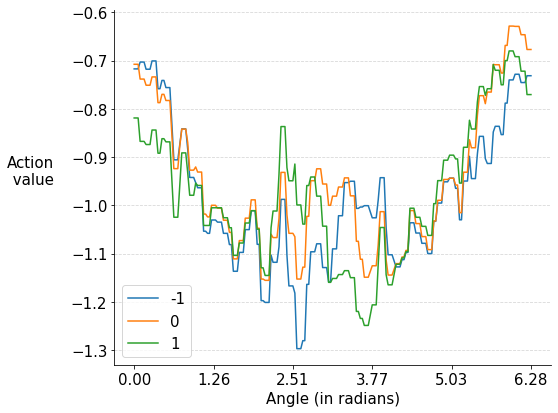

In [28]:
plot_values_from_agent('../results/test_exp/dummy_8tilings_0.npy', run_idx=0)

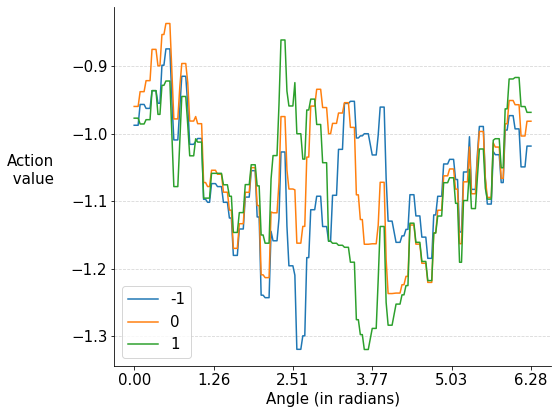

In [29]:
plot_values_from_agent('../results/test_exp/dummy_8tilings_0.npy', run_idx=0)

128
[-0.106 -0.049 -0.117  0.    -0.044  0.    -0.047  0.    -0.065 -0.017
 -0.075  0.     0.     0.     0.     0.    -0.046 -0.049 -0.066  0.
 -0.103  0.    -0.098  0.    -0.065  0.    -0.075  0.     0.    -0.017
  0.     0.     0.    -0.049  0.     0.    -0.059 -0.046 -0.117  0.
 -0.08   0.    -0.043 -0.047 -0.029 -0.017 -0.032  0.    -0.059 -0.096
 -0.066 -0.051 -0.044  0.     0.    -0.047 -0.036 -0.046 -0.032 -0.043
  0.     0.     0.     0.     0.    -0.046 -0.115  0.    -0.103  0.
  0.    -0.098 -0.036  0.     0.    -0.043  0.    -0.046 -0.032  0.
  0.     0.     0.     0.    -0.059 -0.046 -0.115 -0.051 -0.08   0.
  0.    -0.09   0.    -0.046 -0.032  0.     0.    -0.046 -0.115  0.
 -0.044 -0.059  0.    -0.098  0.    -0.065  0.    -0.075  0.     0.
 -0.017  0.     0.    -0.046 -0.049 -0.066  0.    -0.059  0.    -0.051
  0.    -0.08   0.    -0.09   0.    -0.029 -0.017 -0.032 -0.52 ]
[  9  29  45  57  78  94 110 126 128]
[138 158 174 186 207 223 239 255 257]
[267 287 303 315 336 352

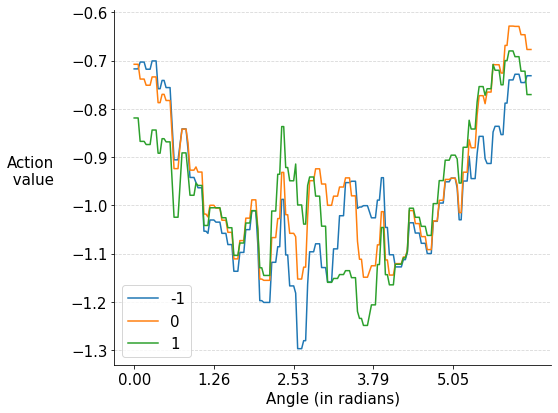

In [22]:
plot_values('../results/test_exp/dummy_8tilings_0.npy', run_idx=0)

showing values only for run_idx=0


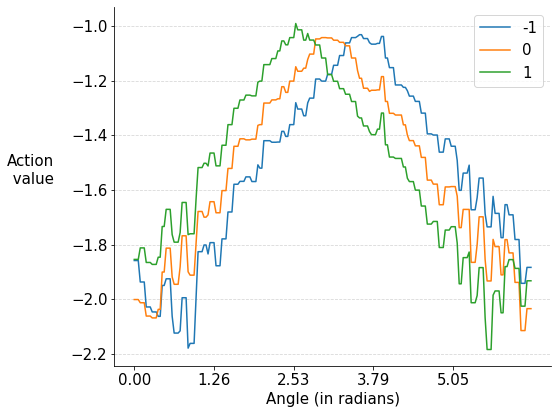

In [30]:
plot_values('../results/test_exp/dummy_8tilings_epsdecay_0.npy', run_idx=0)

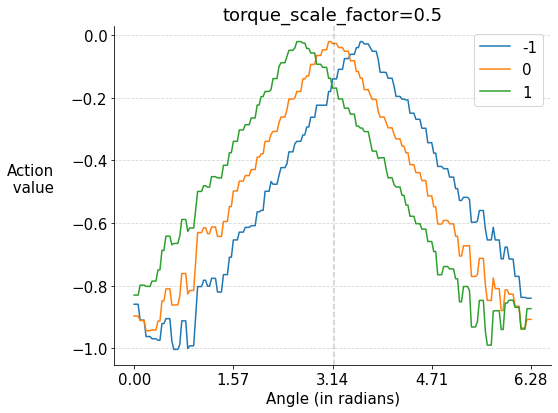

In [61]:
plot_values_from_agent('../results/test_exp/dummy_torque0.5_0.npy', run_idx=0, title='torque_scale_factor=0.5')
# torque_scale_factor = 0.5

Learned reward rate: 0.0


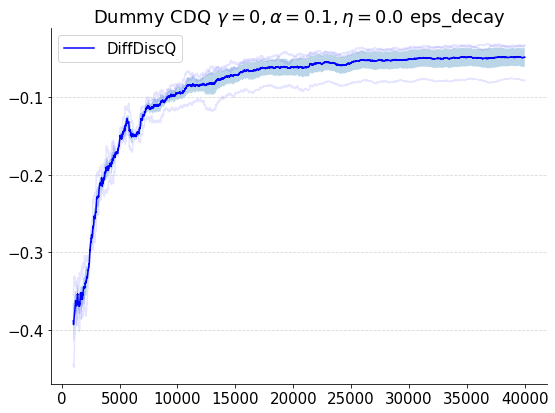

In [33]:
filenames = [('../results/test_exp/', 'dummy_8tilings_epsdecay_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'Dummy CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)

## Making the effect of actions much smaller

Learned reward rate: 0.0


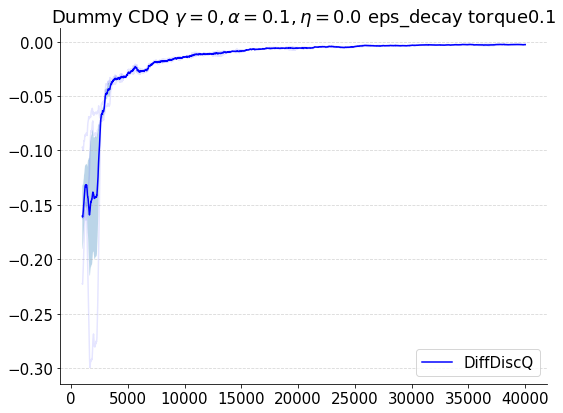

In [41]:
filenames = [('../results/test_exp/', 'dummy_torque0.1.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'Dummy CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay torque0.1', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)

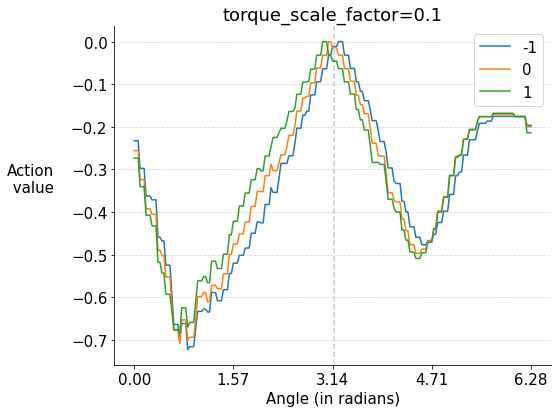

In [62]:
plot_values_from_agent('../results/test_exp/dummy_torque0.1.npy', run_idx=0, title='torque_scale_factor=0.1')

Learned reward rate: 0.0


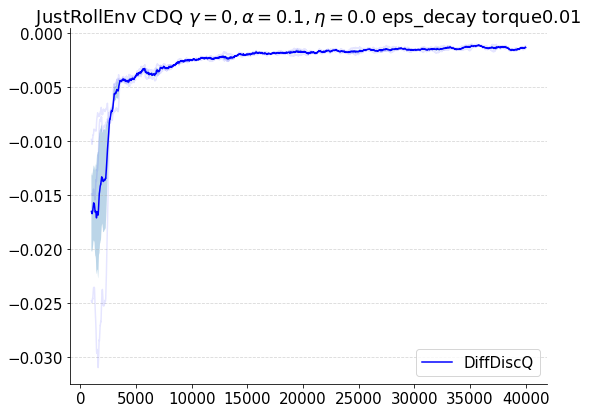

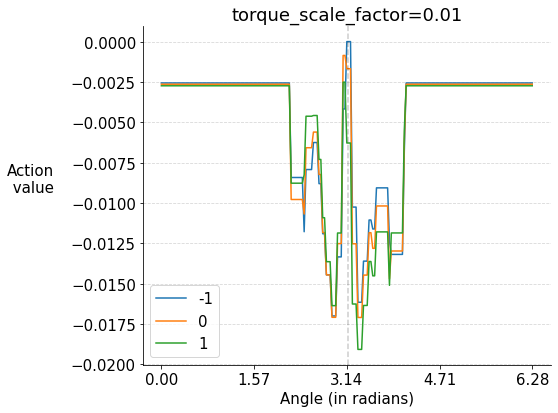

In [63]:
# torque_scale_factor = 0.01
filenames = [('../results/test_exp/', 'dummy_torque0.01_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay torque0.01', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, title='torque_scale_factor=0.01')

In [ ]:
data = np.load('../spaceapps-ksp-ai/results/test_exp/dummy_0.npy', allow_pickle=True).item()
actions = data['action'][0]  # for only the first run

fig, ax = plt.subplots(1, 3, figsize=(24,6))
y_upper_lim = 10000
num_bins = 4

for i in range(3):
    indices = np.arange(actions.shape[0])[actions==i]
    ax[i].hist(indices, num_bins)
    ax[i].set_ylim(0, y_upper_lim)

In [21]:
angles = np.linspace(0, 2*np.pi, 200)
angles.shape

(200,)

## Testing on KSP

Learned reward rate: 0.0


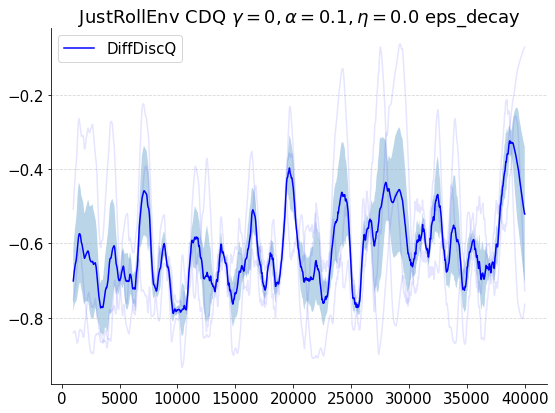

In [36]:
filenames = [('../results/test_exp/', 'simpler_detumbler_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)

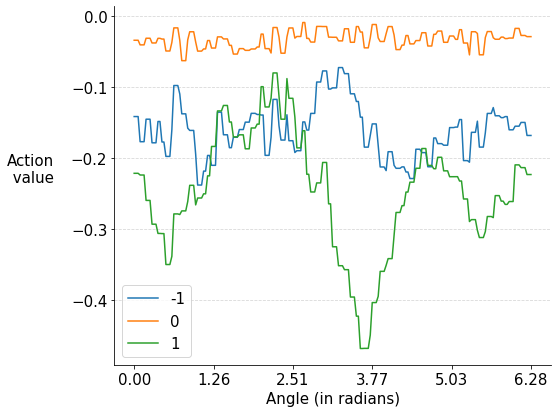

In [40]:
plot_values_from_agent('../results/test_exp/simpler_detumbler_0.npy', run_idx=2)

Learned reward rate: 0.0


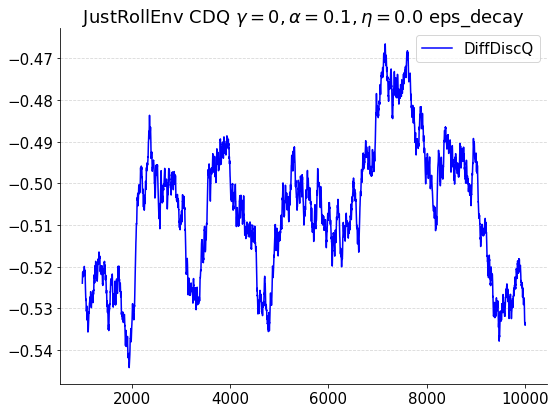

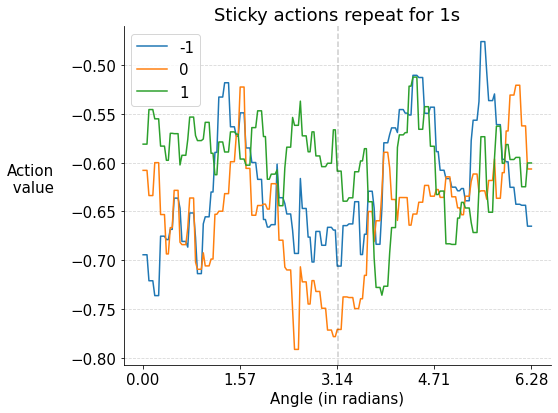

In [64]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_0_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, title='Sticky actions repeat for 1s')

Learned reward rate: 0.0


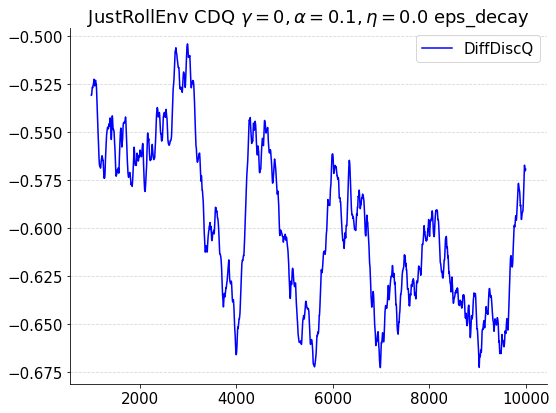

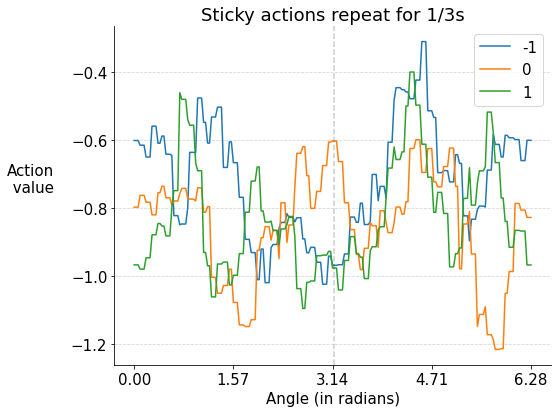

In [65]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_sticky1by3_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.1, \eta=0.0$ eps_decay', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, title='Sticky actions repeat for 1/3s')

Learned reward rate: 0.0


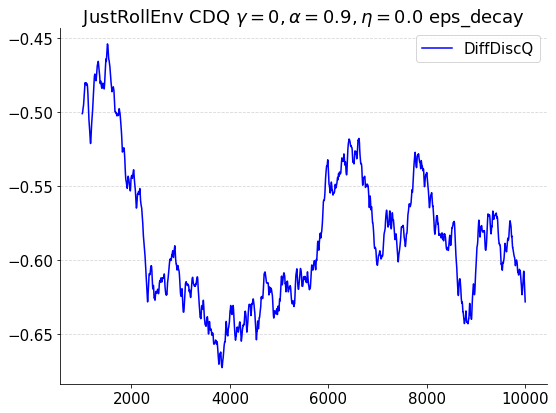

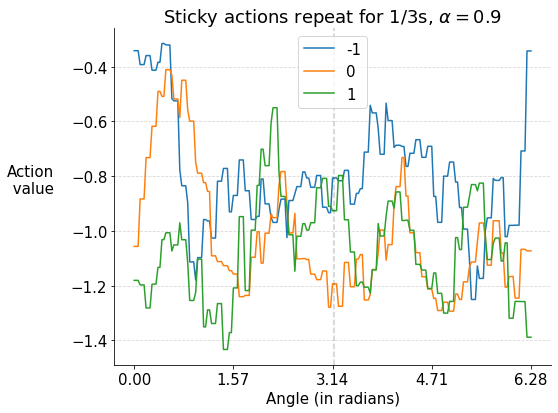

In [66]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_sticky1by3_alpha0.9_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1000, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.9, \eta=0.0$ eps_decay', final=False, plot_all_runs=True,
                    print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.9$')

### debugging with a single tiling

Learned reward rate: 0.0


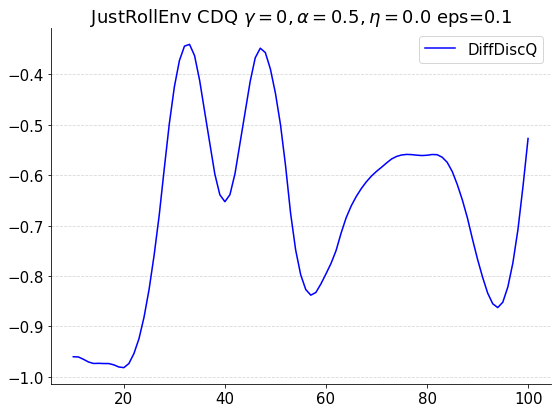

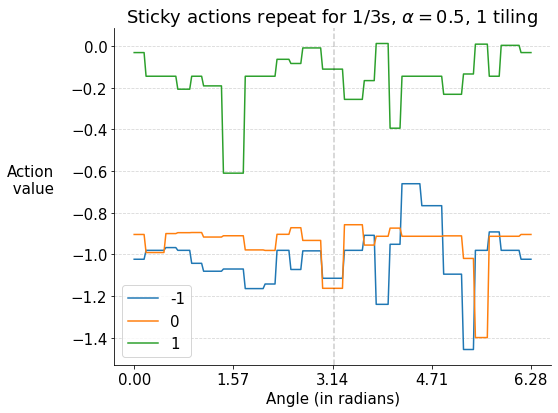

In [69]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


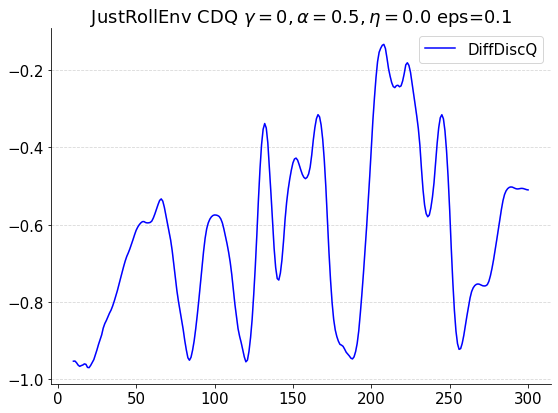

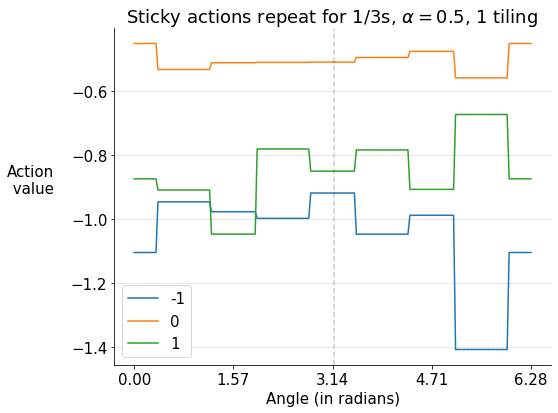

In [70]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


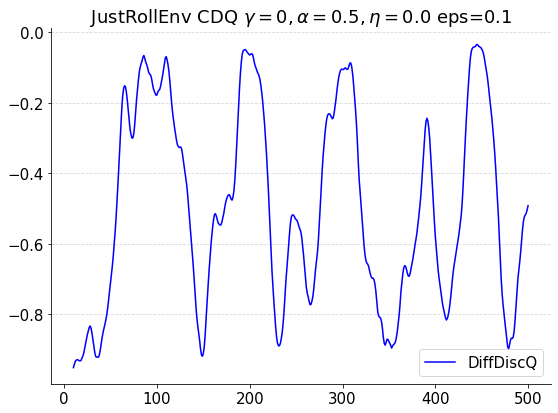

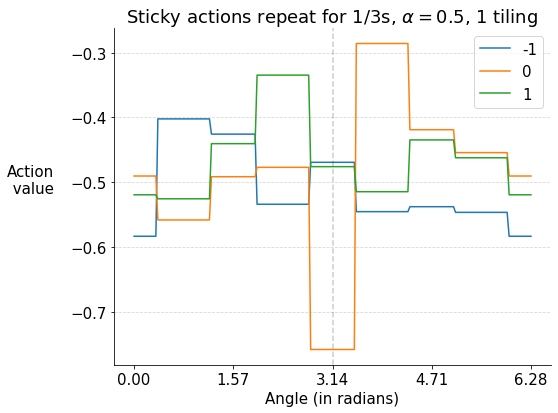

In [71]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


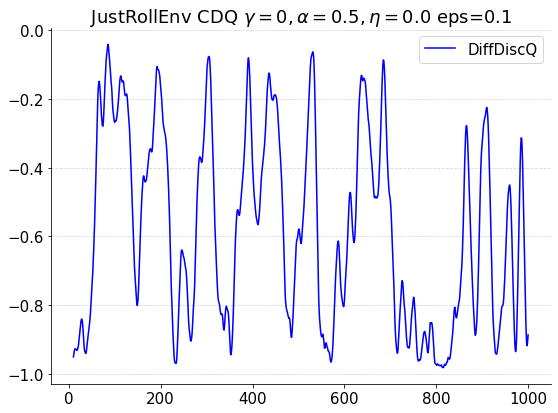

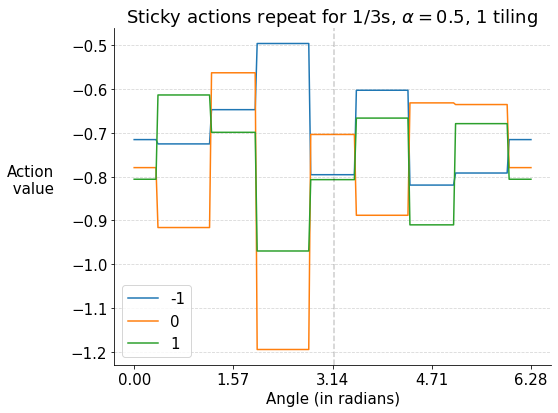

In [72]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


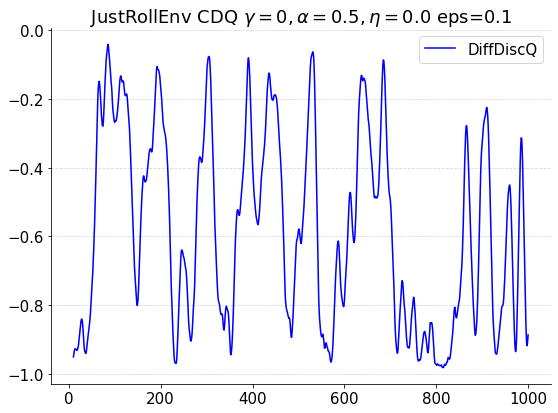

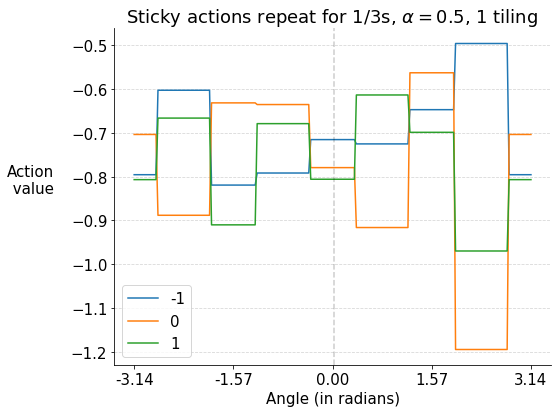

In [74]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


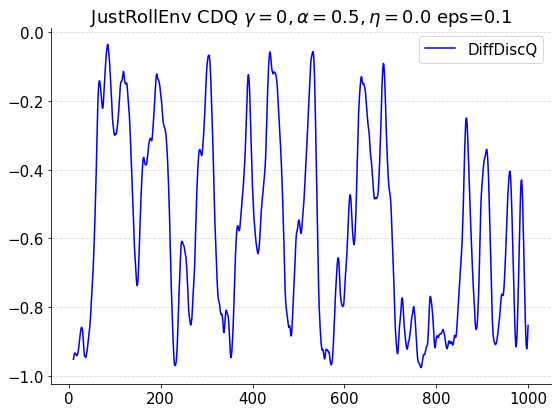

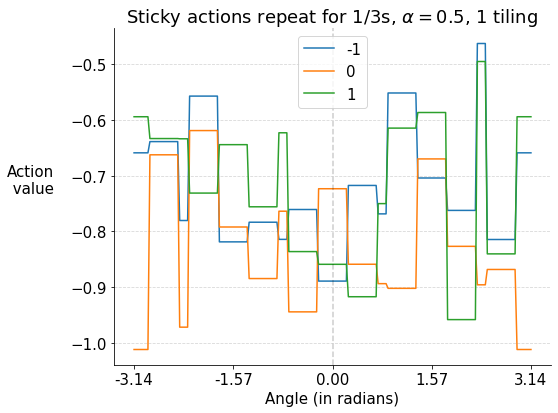

In [75]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

Learned reward rate: 0.0


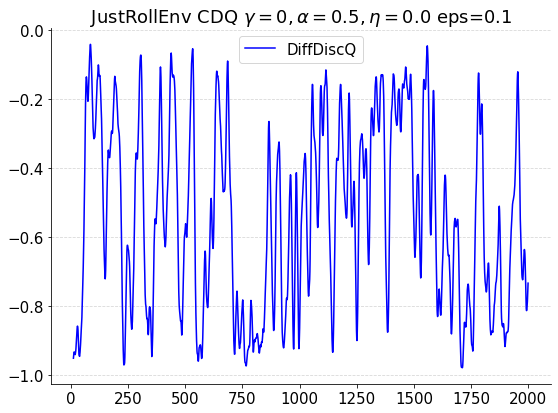

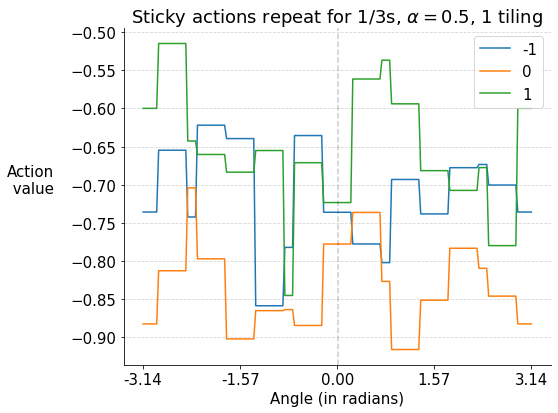

In [76]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling')

### just one action now

Learned reward rate: 0.0


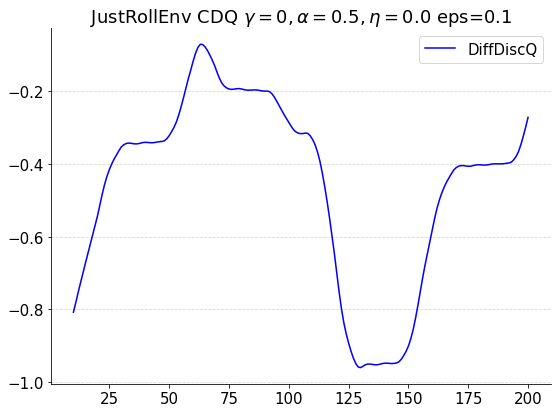

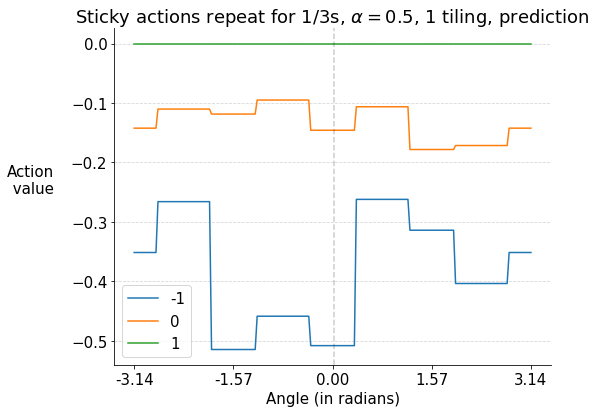

In [78]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

Learned reward rate: 0.0


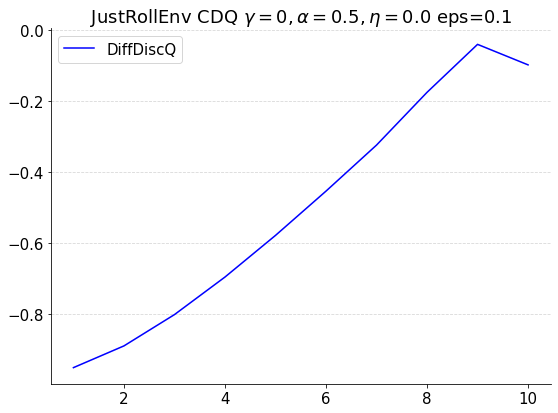

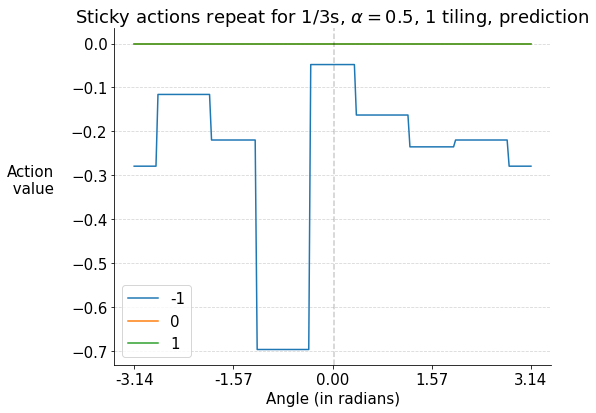

In [81]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

Learned reward rate: 0.0


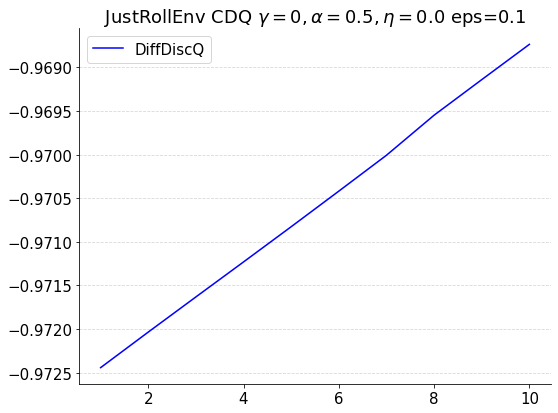

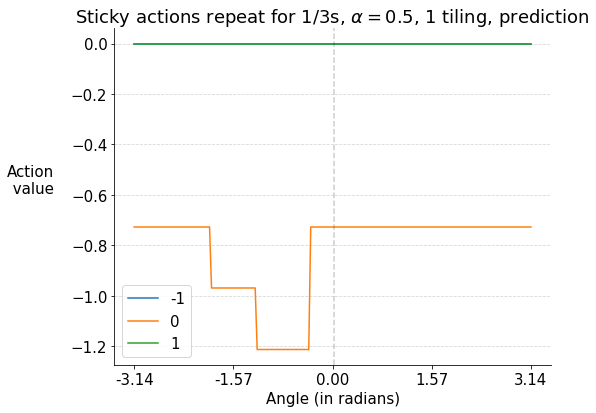

In [82]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

Learned reward rate: 0.0


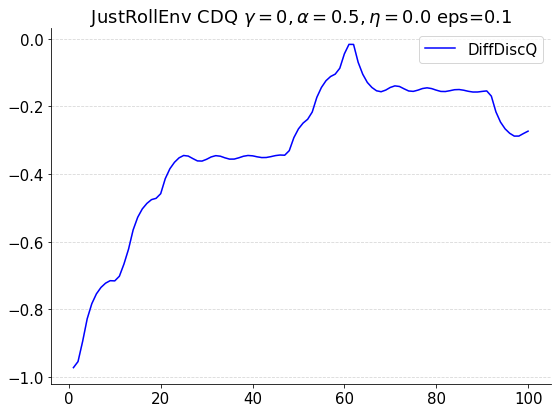

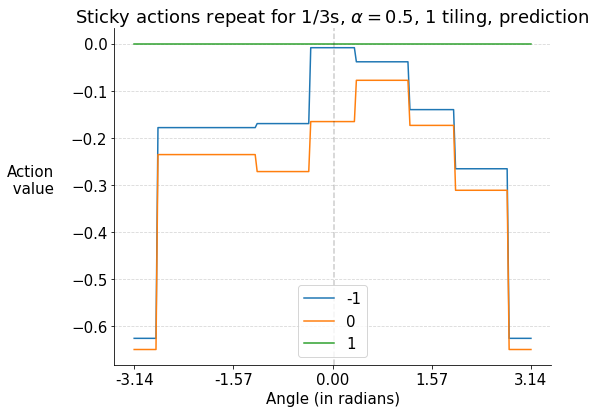

In [86]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=1, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

In [87]:
data = np.load('../results/test_exp/linear_detumbler_simpler_1tiling_prediction_0.npy', allow_pickle=True).item()
angles = data['angle'][0]  # for only the first run
angles

array([ 3.055,  2.999,  2.812,  2.601,  2.462,  2.37 ,  2.31 ,  2.271,
        2.248,  2.25 ,  2.207,  2.093,  1.955,  1.777,  1.659,  1.581,
        1.53 ,  1.495,  1.483,  1.44 ,  1.3  ,  1.209,  1.149,  1.108,
        1.086,  1.091,  1.114,  1.136,  1.138,  1.121,  1.099,  1.087,
        1.092,  1.107,  1.119,  1.119,  1.107,  1.093,  1.086,  1.089,
        1.098,  1.105,  1.104,  1.096,  1.087,  1.081,  1.083,  1.041,
        0.92 ,  0.839,  0.785,  0.75 ,  0.682,  0.546,  0.454,  0.391,
        0.352,  0.33 ,  0.276,  0.142,  0.054, -0.055, -0.22 , -0.331,
       -0.408, -0.454, -0.485, -0.494, -0.479, -0.454, -0.439, -0.445,
       -0.467, -0.487, -0.491, -0.479, -0.464, -0.458, -0.465, -0.479,
       -0.491, -0.492, -0.484, -0.475, -0.473, -0.48 , -0.49 , -0.496,
       -0.496, -0.491, -0.486, -0.534, -0.681, -0.776, -0.838, -0.88 ,
       -0.906, -0.905, -0.882, -0.86 , -0.855], dtype=float32)

Learned reward rate: 0.0


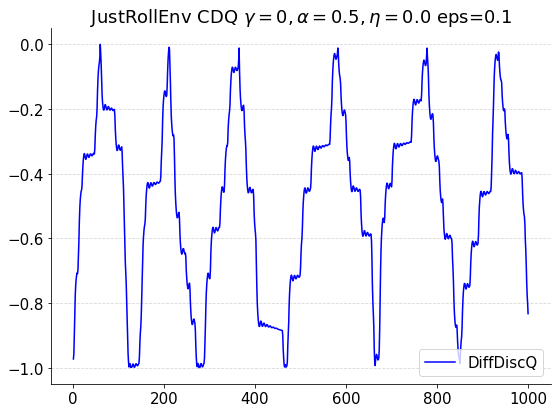

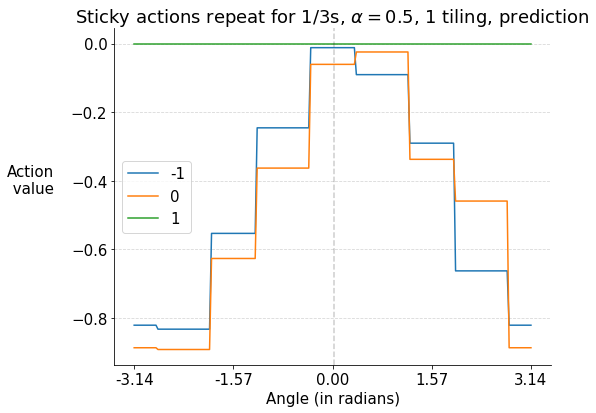

In [88]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

Learned reward rate: 0.0


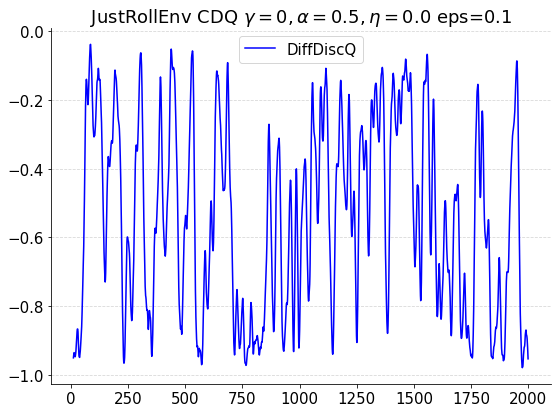

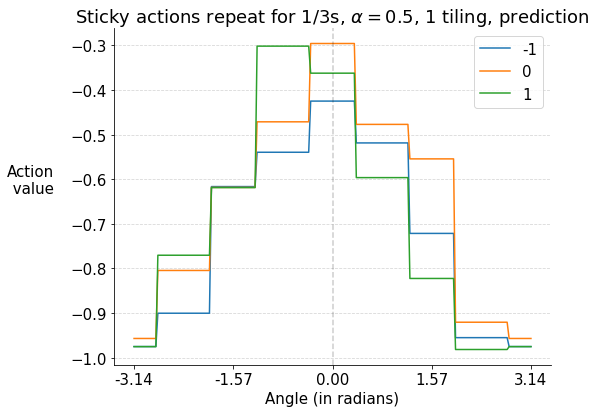

In [89]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_prediction_0.npy'),]

plot_learning_curve(filenames, item='reward', window=10, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.5$, 1 tiling, prediction')

Learned reward rate: 0.0


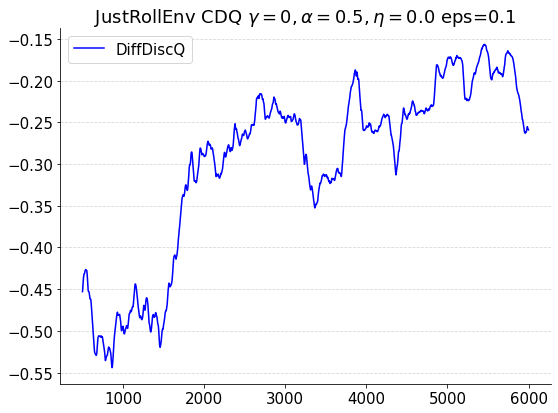

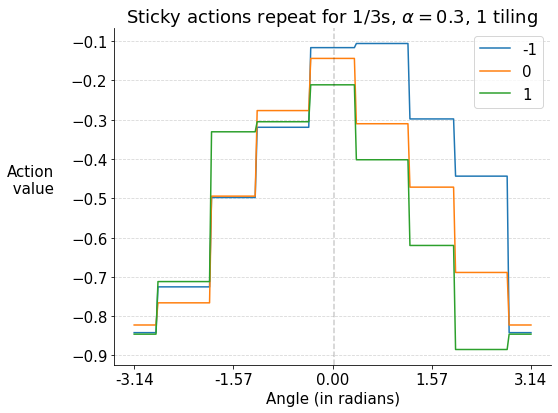

In [92]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_1tiling_0.npy'),]

plot_learning_curve(filenames, item='reward', window=500, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.5, \eta=0.0$ eps=0.1', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.3$, 1 tiling')

Learned reward rate: 0.0


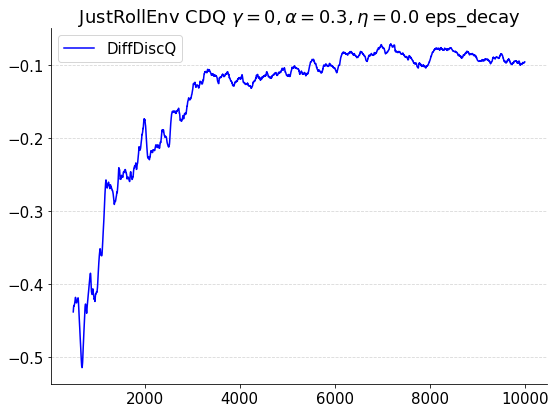

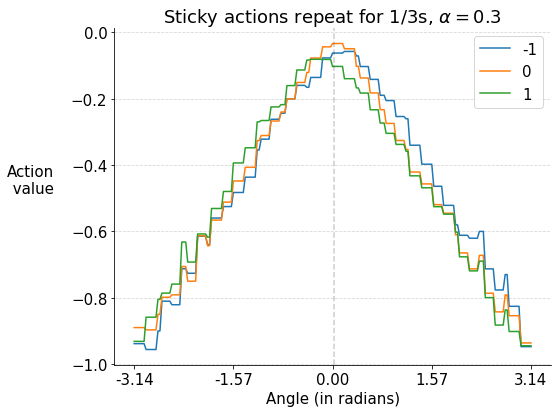

In [95]:
filenames = [('../results/test_exp/', 'linear_detumbler_simpler_0.npy'),]

plot_learning_curve(filenames, item='reward', window=500, #y_lims=(-0.1, 0.1),
                    title=r'JustRollEnv CDQ $\gamma=0, \alpha=0.3, \eta=0.0$ eps_decay', final=False, 
                    plot_all_runs=True, print_final_reward_rate=True)
plot_values_from_agent(filenames[0][0] + filenames[0][1], run_idx=0, 
                       title=r'Sticky actions repeat for 1/3s, $\alpha=0.3$')